In [1]:
pip install folium
pip install geopandas

SyntaxError: invalid syntax (3036988125.py, line 1)

In [15]:
import folium
from folium.plugins import HeatMap
from folium.features import GeoJsonTooltip
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
import requests
import matplotlib.pyplot as plt

# Phân tích thăm dò (EDA)

## Đọc dữ liệu 


           GID_2 GID_0  COUNTRY     GID_1  NAME_1 NL_NAME_1   NAME_2  \
238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA  Hà Đông   

    VARNAME_2 NL_NAME_2 TYPE_2       ENGTYPE_2 CC_2    HASC_2  \
238   Ha Dong        NA   Quận  Urban District   NA  VN.ND.HH   

                                              geometry  
238  POLYGON ((105.71912 20.9277, 105.71861 20.9272...  


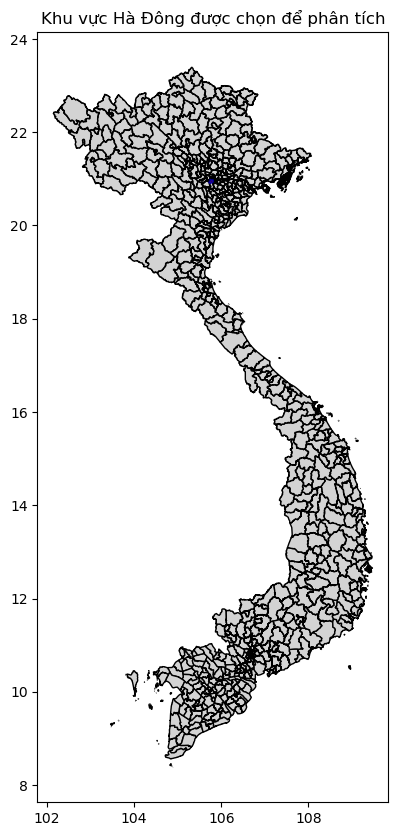

In [3]:
# Đọc dữ liệu bản đồ địa giới hành chính

# Đường dẫn đến tệp Shapefile (ví dụ như "gadm41_VNM_0.shp" hoặc tệp tương ứng bạn muốn phân tích)
file_path = "/Users/fuongfotfet/Desktop/vcb/gadm41_VNM_shp/gadm41_VNM_2.shp"  # thay "path_to_your_file" bằng đường dẫn thực tế của tệp

# Đọc dữ liệu từ Shapefile
gdf = gpd.read_file(file_path)

# Lọc khu vực hành chính muốn phân tích, ví dụ: "Hà Đông - Hà Nội"
selected_district = "Hà Đông"  # Tên khu vực bạn muốn phân tích
selected_gdf = gdf[gdf['NAME_2'] == selected_district]

# Kiểm tra dữ liệu đã lọc
print(selected_gdf)

# Trực quan hóa khu vực đã chọn
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="lightgrey", edgecolor="black")  # Hiển thị toàn bộ bản đồ hành chính
selected_gdf.plot(ax=ax, color="purple", edgecolor="blue", alpha=0.5)  # Khu vực được chọn

# Thêm tiêu đề và hiển thị
plt.title(f"Khu vực {selected_district} được chọn để phân tích")
plt.show()

In [4]:
# Lấy tọa độ trung tâm Hà Đông để tạo bản đồ
map_center = [20.9614, 105.7636]  # Tọa độ gần trung tâm Hà Đông

# Tạo bản đồ Folium
m = folium.Map(location=map_center, zoom_start=13)

# Thêm lớp đa giác Hà Đông vào bản đồ
folium.GeoJson(
    selected_gdf,
    style_function=lambda feature: {
        'fillColor': 'purple',
        'color': 'blue',
        'weight': 2,
        'fillOpacity': 0.3,
    },
    tooltip=GeoJsonTooltip(fields=["NAME_2"], aliases=["Khu vực:"], sticky=True)
).add_to(m)
m.save("ATM_map_hadong.html")

In [5]:
# Đọc dữ liệu ATM

# Đọc dữ liệu từ tệp CSV
atm_data = pd.read_csv("/Users/fuongfotfet/Desktop/vcb/testfile/ATM_HaNoi_cleaned.csv")

# Kiểm tra các giá trị trong cột "LONGITUDE" và "LATITUDE" xem có giá trị không hợp lệ không
# Loại bỏ các hàng có khoảng trống hoặc giá trị không phải số
atm_data = atm_data[atm_data['LONGITUDE'].apply(lambda x: str(x).strip()).str.replace(' ', '') != '']
atm_data = atm_data[atm_data['LATITUDE'].apply(lambda x: str(x).strip()).str.replace(' ', '') != '']

# Chuyển đổi cột "LONGITUDE" và "LATITUDE" sang kiểu float
atm_data['LONGITUDE'] = atm_data['LONGITUDE'].astype(float)
atm_data['LATITUDE'] = atm_data['LATITUDE'].astype(float)

# Tạo cột geometry từ tọa độ
atm_data['geometry'] = atm_data.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)

# Chuyển đổi thành GeoDataFrame
atm_gdf = gpd.GeoDataFrame(atm_data, geometry='geometry', crs="EPSG:4326")

# Kiểm tra kết quả
print(atm_gdf.head())

     ATM_ID                            NAME                          ADR_01  \
0  10800002  TRU SO CN SO GIAO DICH          11 LANG HA                       
1  10800003  PGD TRAN QUANG KHAI             198 TRAN QUANG KHAI              
2  10800009  PGD CAU GO                      110 CAU GO                       
3  10800011  TOA NHA MOBIFONE                SO 1 PHAM VAN BACH               
4  10800012  BAO QUAN DOI                    07 PHAN DINH PHUNG               

                           ADR_02           CITY   LATITUDE   LONGITUDE  \
0  BA DINH                         HA NOI         21.021369  105.818518   
1  HOAN KIEM                       HA NOI         21.028844  105.857461   
2  HOAN KIEM                       HA NOI         21.032341  105.851745   
3  CAU GIAY                        HA NOI         21.023990  105.788938   
4  BA DINH                         HA NOI         21.039794  105.846178   

  Địa chỉ lắp đặt                    geometry  
0            TSCN  POINT (

In [12]:
def filter_by_address(dataframe, keyword):
    """
    Lọc ra các dòng dữ liệu có chứa keyword trong cột address.

    Parameters:
    dataframe (pd.DataFrame): DataFrame chứa dữ liệu.
    keyword (str): Từ khóa để tìm kiếm trong cột address.

    Returns:
    pd.DataFrame: DataFrame chứa các dòng có từ khóa trong cột address.
    """
    # Lọc các dòng có chứa từ khóa trong cột 'address'
    filtered_df = dataframe[dataframe['ADR_02'].str.contains(keyword, case=False, na=False)]
    return filtered_df

# Ví dụ sử dụng hàm
# Giả sử bạn đã tải dữ liệu vào DataFrame tên là `du_lieu_sieuthi`
# du_lieu_sieuthi = pd.read_csv("path_to_your_data.csv")  # Đọc dữ liệu từ tệp

# Sử dụng hàm để lọc dữ liệu chứa "Hà Đông" trong cột 'address'
filtered_data = filter_by_address(atm_gdf, "HA DONG")
print(filtered_data.head())

       ATM_ID                            NAME                          ADR_01  \
62   10800336  PHENIKAA                        TRUONG  DAI HOC PHENIKAA, YEN    
82   10800397  TOA NHA TSQ MO LAO              CT1 KDT MO LAO                   
85   10800400  BHXH TP HA NOI                  15 CAU DO                        
111  10800514  10A QUANG TRUNG                 10 QUANG TRUNG, P QUANG TRUNG    
112  10800516  PGD QUANG TRUNG                 PGD QUANG TRUNG SO 80 QUANG TR   

                             ADR_02           CITY   LATITUDE   LONGITUDE  \
62   HA DONG                         HA NOI         20.962822  105.748815   
82   HA DONG                         HA NOI         20.986552  105.780302   
85   HA DONG                         HA NOI         20.964920  105.771030   
111  HA DONG                         HA NOI         20.971941  105.776733   
112  HA DONG                         HA NOI         20.969898  105.774452   

    Địa chỉ lắp đặt                    geometry  


In [13]:
# Lấy trung tâm của Hà Nội để khởi tạo bản đồ
map_center = [20.964920, 105.771030]  # Tọa độ gần trung tâm Hà Nội

# Tạo bản đồ Folium
m = folium.Map(location=map_center, zoom_start=12)

# Thêm các điểm ATM vào bản đồ
for idx, row in filtered_data.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=f"{row['NAME']} - {row['ADR_01']}",
        tooltip=row['NAME'],
        icon=folium.Icon(color="blue", icon="bank", prefix="fa")
    ).add_to(m)
    
folium.GeoJson(
    selected_gdf,
    style_function=lambda feature: {
        'fillColor': 'purple',
        'color': 'blue',
        'weight': 2,
        'fillOpacity': 0.3,
    },
    tooltip=GeoJsonTooltip(fields=["NAME_2"], aliases=["Khu vực:"], sticky=True)
).add_to(m)
# Lưu bản đồ vào file HTML
m.save("ATM_map_hanoi.html")

print("Bản đồ đã được lưu vào file ATM_map_hanoi.html")

Bản đồ đã được lưu vào file ATM_map_hanoi.html


In [14]:
# Đọc dữ liệu dân số
# Đọc dữ liệu dân số từ tệp cục bộ (sau khi đã tải xuống từ HDX hoặc nguồn khác)
population_data = pd.read_csv("/Users/fuongfotfet/Downloads/vnm_general_2020.csv")  # Thay thế bằng đường dẫn thực tế

# Đổi tên các cột cho phù hợp (giả sử có các cột 'longitude', 'latitude', và 'population')
population_data.columns = ['longitude', 'latitude', 'population']

# Chuyển đổi thành GeoDataFrame
population_gdf = gpd.GeoDataFrame(
    population_data, 
    geometry=gpd.points_from_xy(population_data.longitude, population_data.latitude),
    crs="EPSG:4326"
)

# Kiểm tra dữ liệu sau khi xử lý
print(population_gdf.head())

    longitude   latitude  population                    geometry
0  105.304861  23.371806    7.559477  POINT (105.30486 23.37181)
1  105.305139  23.371806    7.559477  POINT (105.30514 23.37181)
2  105.305417  23.371806    7.559477  POINT (105.30542 23.37181)
3  105.304861  23.371528    7.559477  POINT (105.30486 23.37153)
4  105.305139  23.371528    7.559477  POINT (105.30514 23.37153)


In [22]:
hanoi_admin = gdf[gdf['NAME_1'] == 'Hà Nội']  # Giả sử NAME_1 chứa tên tỉnh/thành phố

# Thực hiện Spatial Join để lọc các điểm dân số nằm trong Hà Nội
population_in_hanoi = gpd.sjoin(population_gdf, hanoi_admin, how="inner", predicate="within")

# Tính tổng dân số ở Hà Nội
total_population_hanoi = population_in_hanoi['population'].sum()
print(f"Tổng dân số ở Hà Nội: {total_population_hanoi}")

Tổng dân số ở Hà Nội: 8275396.187977999


In [16]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def calculate_population_for_district(district_name, gdf, population_gdf):
    """
    Tính tổng dân số cho một khu vực cụ thể.
    
    Parameters:
        district_name (str): Tên của khu vực muốn tính dân số.
        gdf (GeoDataFrame): Dữ liệu bản đồ hành chính (GeoDataFrame).
        population_gdf (GeoDataFrame): Dữ liệu dân số (GeoDataFrame).
        
    Returns:
        int: Tổng dân số trong khu vực được chọn.
    """
    # Lọc khu vực hành chính muốn phân tích
    selected_gdf = gdf[gdf['NAME_2'] == district_name]
    
    if selected_gdf.empty:
        print(f"Khu vực {district_name} không tồn tại trong dữ liệu!")
        return None
    
    # Thực hiện Spatial Join để lọc các điểm dân số nằm trong khu vực
    population_in_district = gpd.sjoin(population_gdf, selected_gdf, how="inner", predicate="within")
    
    # Tính tổng dân số
    total_population = population_in_district['population'].sum()
    print(f"Tổng dân số ở {district_name}: {total_population}")
    
    return total_population

# Sử dụng hàm cho khu vực Hà Đông
district_name = "Hà Đông"
total_population_hadong = calculate_population_for_district(district_name, gdf, population_gdf)

Tổng dân số ở Hà Đông: 345197.126241


In [18]:
from folium.plugins import HeatMap

def create_heatmap_for_district(district_name, gdf, population_gdf):
    """
    Tạo Heatmap hiển thị mật độ dân cư trong một khu vực cụ thể.
    
    Parameters:
        district_name (str): Tên của khu vực muốn hiển thị.
        gdf (GeoDataFrame): Dữ liệu bản đồ hành chính (GeoDataFrame).
        population_gdf (GeoDataFrame): Dữ liệu dân số (GeoDataFrame).
    
    Returns:
        folium.Map: Bản đồ Folium hiển thị Heatmap dân cư.
    """
    # Lọc khu vực hành chính muốn phân tích
    selected_gdf = gdf[gdf['NAME_2'] == district_name]
    
    if selected_gdf.empty:
        print(f"Khu vực {district_name} không tồn tại trong dữ liệu!")
        return None
    
    # Thực hiện Spatial Join để lọc các điểm dân số nằm trong khu vực
    population_in_district = gpd.sjoin(population_gdf, selected_gdf, how="inner", predicate="within")
    
    # Tạo bản đồ trung tâm tại Hà Đông
    district_center = selected_gdf.geometry.centroid.iloc[0]
    heatmap = folium.Map(location=[district_center.y, district_center.x], zoom_start=12)
    
    # Thêm ranh giới của Hà Đông
    folium.GeoJson(
        selected_gdf.geometry,
        name=f"Boundary of {district_name}",
        style_function=lambda x: {"color": "blue", "weight": 2, "fillOpacity": 0.1},
    ).add_to(heatmap)
    
    # Chuẩn bị dữ liệu cho Heatmap
    heatmap_data = [
        [row.geometry.y, row.geometry.x, row['population']]
        for _, row in population_in_district.iterrows()
    ]
    
    # Thêm Heatmap vào bản đồ
    HeatMap(heatmap_data, radius=10, blur=15, max_zoom=12).add_to(heatmap)
    
    # Thêm điều khiển lớp
    folium.LayerControl().add_to(heatmap)
    
    return heatmap

# Tạo Heatmap cho Hà Đông
district_name = "Hà Đông"
hadong_heatmap = create_heatmap_for_district(district_name, gdf, population_gdf)

# Lưu bản đồ hoặc hiển thị
hadong_heatmap.save("hadong_heatmap.html")
hadong_heatmap

/var/folders/sq/kyw5wnpn4jq0h5qkwphw144h0000gn/T/ipykernel_54793/717467226.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_center = selected_gdf.geometry.centroid.iloc[0]


In [23]:
# Lấy tọa độ trung tâm Hà Đông để tạo bản đồ
map_center = [20.9614, 105.7636]  # Tọa độ gần trung tâm Hà Đông

# Tạo bản đồ Folium
m = folium.Map(location=map_center, zoom_start=13)

# Thêm lớp đa giác Hà Đông vào bản đồ
folium.GeoJson(
    selected_gdf,
    style_function=lambda feature: {
        'fillColor': 'purple',
        'color': 'blue',
        'weight': 2,
        'fillOpacity': 0.3,
    },
    tooltip=GeoJsonTooltip(fields=["NAME_2"], aliases=["Khu vực:"], sticky=True)
).add_to(m)

# Thêm các điểm ATM vào bản đồ
for idx, row in filtered_data.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=f"{row['NAME']} - {row['ADR_01']}",
        tooltip=row['NAME'],
        icon=folium.Icon(color="blue", icon="bank", prefix="fa")
    ).add_to(m)

# Lưu bản đồ vào file HTML
m.save("ATM_map_hadong.html")

print("Bản đồ đã được lưu vào file ATM_map_hadong.html")

Bản đồ đã được lưu vào file ATM_map_hadong.html


# Tạo map

In [24]:
# Isochrone
def get_isochrone(lat, lon, duration, api_key):
    url = "https://api.openrouteservice.org/v2/isochrones/foot-walking"
    headers = {
        'Authorization': api_key
    }
    params = {
        'locations': [[lon, lat]],
        'range': [duration * 60],
        'interval': duration * 60,
        'attributes': ['total_pop']
    }
    
    response = requests.post(url, headers=headers, json=params)
    
    # Kiểm tra trạng thái phản hồi
    if response.status_code != 200:
        print("Lỗi API:", response.status_code, response.text)
        return None
    
    data = response.json()
    
    # Kiểm tra xem 'features' có trong phản hồi không
    if 'features' not in data or not data['features']:
        print("Không tìm thấy 'features' trong phản hồi API:", data)
        return None
    
    return data['features'][0]['geometry']

# Ví dụ sử dụng hàm cho một điểm bán hàng
lat, lon = 21.986552, 106.780302  # Tọa độ của điểm bán hàng
api_key = '5b3ce3597851110001cf62487450313b6e8642c8b42c0522c29c8c33'  # Thay thế bằng API key của bạn
isochrone = get_isochrone(lat, lon, duration=15, api_key=api_key)

# Hiển thị Isochrone trên bản đồ nếu tồn tại
if isochrone:
    m = folium.Map(location=[lat, lon], zoom_start=13)
    folium.GeoJson(isochrone, style_function=lambda x: {'fillColor': 'blue', 'color': 'blue'}).add_to(m)
    m.save("isochrone_map.html")
    print("Bản đồ Isochrone đã được lưu vào file isochrone_map.html")
else:
    print("Không thể tạo Isochrone.")

Bản đồ Isochrone đã được lưu vào file isochrone_map.html


In [25]:
# Hàm lấy Isochrone cho từng điểm ATM
def get_isochrone(lat, lon, duration, api_key):
    url = "https://api.openrouteservice.org/v2/isochrones/foot-walking"
    headers = {'Authorization': api_key}
    params = {
        'locations': [[lon, lat]],
        'range': [duration * 60],
        'interval': duration * 60,
    }
    
    response = requests.post(url, headers=headers, json=params)
    if response.status_code == 200:
        data = response.json()
        if 'features' in data and len(data['features']) > 0:
            return data['features'][0]['geometry']
    return None

# Hàm tạo vùng accessible_area
def create_accessible_area(atm_gdf, api_key, duration=15):
    accessible_area = gpd.GeoDataFrame(columns=['geometry'])

    for idx, row in atm_gdf.iterrows():
        lat, lon = row['LATITUDE'], row['LONGITUDE']
        isochrone = get_isochrone(lat, lon, duration, api_key)
        
        if isochrone:
            isochrone_polygon = Polygon(isochrone['coordinates'][0])
            temp_gdf = gpd.GeoDataFrame({'geometry': [isochrone_polygon]}, crs="EPSG:4326")
            accessible_area = pd.concat([accessible_area, temp_gdf], ignore_index=True)
    
    accessible_area = accessible_area.unary_union
    return accessible_area

# Lọc dữ liệu dân số chỉ trong khu vực Hà Đông
population_in_hadong = gpd.sjoin(population_gdf, selected_gdf, how="inner", predicate="within")

# Tạo vùng accessible_area
api_key = '5b3ce3597851110001cf62487450313b6e8642c8b42c0522c29c8c33'  # Thay thế bằng API key thực tế
accessible_area = create_accessible_area(filtered_data, api_key)

# Tạo các điểm dân cư có thể tiếp cận và không thể tiếp cận chỉ trong Hà Đông
accessible_points = [(row.geometry.y, row.geometry.x, row.population) for idx, row in population_in_hadong.iterrows() if accessible_area.contains(row.geometry)]
inaccessible_points = [(row.geometry.y, row.geometry.x, row.population) for idx, row in population_in_hadong.iterrows() if not accessible_area.contains(row.geometry)]

# Tạo bản đồ
def create_accessibility_map_with_dots(atm_gdf, selected_gdf, accessible_points, inaccessible_points):
    map_center = [selected_gdf.geometry.centroid.y.values[0], selected_gdf.geometry.centroid.x.values[0]]
    m = folium.Map(location=map_center, zoom_start=13)

    HeatMap(accessible_points, min_opacity=0.1, radius=5, blur=10, gradient={0.4: 'green', 1: 'green'}).add_to(m)
    HeatMap(inaccessible_points, min_opacity=0.1, radius=5, blur=10, gradient={0.4: 'red', 1: 'red'}).add_to(m)
    
    for idx, row in atm_gdf.iterrows():
        folium.Marker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            tooltip=row['NAME'],
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(m)
    
    folium.GeoJson(
        selected_gdf,
        style_function=lambda x: {'fillColor': 'orange', 'color': 'orange', 'weight': 2, 'fillOpacity': 0.1}
    ).add_to(m)
    
    m.save("dot_accessibility_map_hadong.html")
    print("Bản đồ khả năng tiếp cận đã được lưu vào file dot_accessibility_map_hadong.html")

# Gọi hàm để tạo bản đồ
create_accessibility_map_with_dots(filtered_data, selected_gdf, accessible_points, inaccessible_points)

/var/folders/sq/kyw5wnpn4jq0h5qkwphw144h0000gn/T/ipykernel_98351/713349383.py:31: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  accessible_area = accessible_area.unary_union


Bản đồ khả năng tiếp cận đã được lưu vào file dot_accessibility_map_hadong.html


/var/folders/sq/kyw5wnpn4jq0h5qkwphw144h0000gn/T/ipykernel_98351/713349383.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [selected_gdf.geometry.centroid.y.values[0], selected_gdf.geometry.centroid.x.values[0]]


In [26]:
def calculate_population_with_access(population_gdf, accessible_area):
    """
    Tính toán phần trăm dân số có khả năng tiếp cận các điểm ATM trong vùng accessible_area.

    Parameters:
    population_gdf (GeoDataFrame): GeoDataFrame chứa các điểm dân cư và dữ liệu dân số.
    accessible_area (Polygon or MultiPolygon): Vùng tiếp cận hợp nhất từ các điểm ATM.

    Returns:
    float: Phần trăm dân số có khả năng tiếp cận.
    """
    # Lọc các điểm dân cư nằm trong vùng accessible_area
    accessible_population_gdf = population_gdf[population_gdf.geometry.within(accessible_area)]

    # Tính tổng dân số trong khu vực nghiên cứu (Hà Đông)
    total_population = population_gdf['population'].sum()

    # Tính tổng dân số trong vùng accessible_area
    accessible_population = accessible_population_gdf['population'].sum()

    # Tính phần trăm dân số có thể tiếp cận
    access_percentage = (accessible_population / total_population) * 100
    return access_percentage
# Giả sử accessible_area đã được tính toán trước đó
access_percentage = calculate_population_with_access(population_in_hadong, accessible_area)
print(f"Population with Access: {access_percentage:.2f}%")

Population with Access: 41.38%
